In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Lasso, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, FunctionTransformer, normalize
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score

# Others
from sklearn_pandas import DataFrameMapper
import statsmodels.api as sm

In [2]:
# Globals
SEED = 42

In [3]:
# Read in room data
rooms = pd.read_csv('../data/room_data.csv')
rooms = rooms.drop_duplicates()
rooms['isSuperhost'] = rooms['isSuperhost'].astype(int)
rooms['avgRating'] = rooms['avgRating'].fillna(rooms['avgRating'].mean())
rooms = rooms.set_index('id')
rooms.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2435 entries, 18669058 to 16214536
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   cleaning_fee    2435 non-null   int64  
 1   price           2435 non-null   int64  
 2   bedrooms        2428 non-null   float64
 3   beds            2415 non-null   float64
 4   bathrooms       2435 non-null   float64
 5   personCapacity  2435 non-null   int64  
 6   reviewsCount    2435 non-null   int64  
 7   isSuperhost     2435 non-null   int64  
 8   avgRating       2435 non-null   float64
 9   lat             2435 non-null   float64
 10  lng             2435 non-null   float64
dtypes: float64(6), int64(5)
memory usage: 228.3 KB


In [4]:
# Bedrooms and beds have some NaN values. Filling those with zero.
rooms['bedrooms'] = rooms['bedrooms'].fillna(0)
rooms['beds'] = rooms['beds'].fillna(0)

In [5]:
# Check our dataframe contents.
rooms.head()

,cleaning_fee,price,bedrooms,beds,bathrooms,personCapacity,reviewsCount,isSuperhost,avgRating,lat,lng
id,,,,,,,,,,,
18669058,5,10,1.0,1.0,1.0,2,82,0,4.71,4.65030,-74.06013
32308869,12,12,1.0,1.0,1.0,2,52,0,4.50,4.64668,-74.07234
35159913,5,12,1.0,1.0,1.0,2,8,0,5.00,4.58942,-74.07299
37721845,11,11,1.0,1.0,1.0,2,20,0,4.70,4.63778,-74.06339
35522458,8,12,1.0,1.0,1.0,2,18,0,4.94,4.64031,-74.06816


In [6]:
# Read in amenities data from a json object.
with open('../data/amenities_strings.json', 'r') as f:
    amenities_dict = json.load(f)

In [7]:
# Convert each entry in the amenities_dict to a document. Replace spaces with underscores
# any other non-alphanumeric character with and underscore.
corpus = []
key_list = []
for key, word_list in amenities_dict.items():
    
    try:
        integer_key = int(key)
        key_list.append(integer_key)
    except Exception as e:
        raise e
    cleaned_word_list = [re.sub(r'(\s+|\W+)', '_', doc) for doc in word_list]
    document = ' '.join(cleaned_word_list)
    corpus.append(document)

In [8]:
# Fit a CountVectorizer
cv = CountVectorizer()
amenities_vec = cv.fit_transform(corpus)
cv.get_feature_names()[:5]

['air_conditioning',
 'baby_bath',
 'baby_monitor',
 'babysitter_recommendations',
 'baking_sheet']

______
**Amenities data is loaded below.**  
This will be added to the analysis later after dong an initial analysis without it.

In [9]:
# Convert transformed CountVecortizer data to a DataFrame with room ids as
# the index.
amenities_vec = amenities_vec.toarray()
amenities = pd.DataFrame(amenities_vec, index=key_list)
amenities.head()

,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,79,80
6922245,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,1,0,1,0
31137797,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,1,0
31440906,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,1,0
33579033,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,0,0,1,0
7200800,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,1,0


In [10]:
# Validate that the length of the imput list of amenities is equal to the sum
# of the amenities in the row for the equivalent id.
for key, val in amenities_dict.items():
    assert len(val) == sum(amenities.loc[int(key)])

In [11]:
# Compare correlation values for price and log of the price with the features before
# and after taking the log of the feaures.
# price_r and log_price_r os the correlation to normal features.
# price_l and log_price_l is for the correlation with the log of the features. 
rooms['log_price'] = np.log(rooms['price'])
fields_to_compare = ['price', 'log_price',  'bedrooms', 'beds', 'bathrooms','personCapacity',
                     'reviewsCount', 'isSuperhost', 'avgRating', 'cleaning_fee']
log_rooms = rooms[fields_to_compare].copy()
features_to_log = ['bedrooms', 'beds', 'bathrooms', 'personCapacity', 'cleaning_fee']
for feature in features_to_log:
    log_rooms[feature] = np.log1p(log_rooms[feature])
r = rooms[fields_to_compare].corr()
l = log_rooms.corr()
features = ['price', 'log_price']
r[features].merge(l[features], left_index=True, right_index=True, suffixes=('_r', '_l'))

,price_r,log_price_r,price_l,log_price_l
price,1.000000,0.937462,1.000000,0.937462
log_price,0.937462,1.000000,0.937462,1.000000
bedrooms,0.288254,0.268978,0.303728,0.298954
beds,0.237055,0.232581,0.256784,0.258332
bathrooms,0.406953,0.410623,0.450905,0.469571
personCapacity,0.295645,0.286233,0.304884,0.310077
reviewsCount,-0.088857,-0.084103,-0.088857,-0.084103
isSuperhost,-0.061270,-0.046700,-0.061270,-0.046700
avgRating,0.070585,0.076367,0.070585,0.076367
cleaning_fee,0.212214,0.213420,0.015984,0.027427


**Based on the correlation values above price will be fit with the following features:**  
log of bedrooms  
log of beds  
log of bathrooms  
log of personCapacity  
reviewsCount - low correlation so likely noise  
isSuperhost - low correlation so likely noise  
avgRating - low correlation so likely noise  
cleaning_fee  

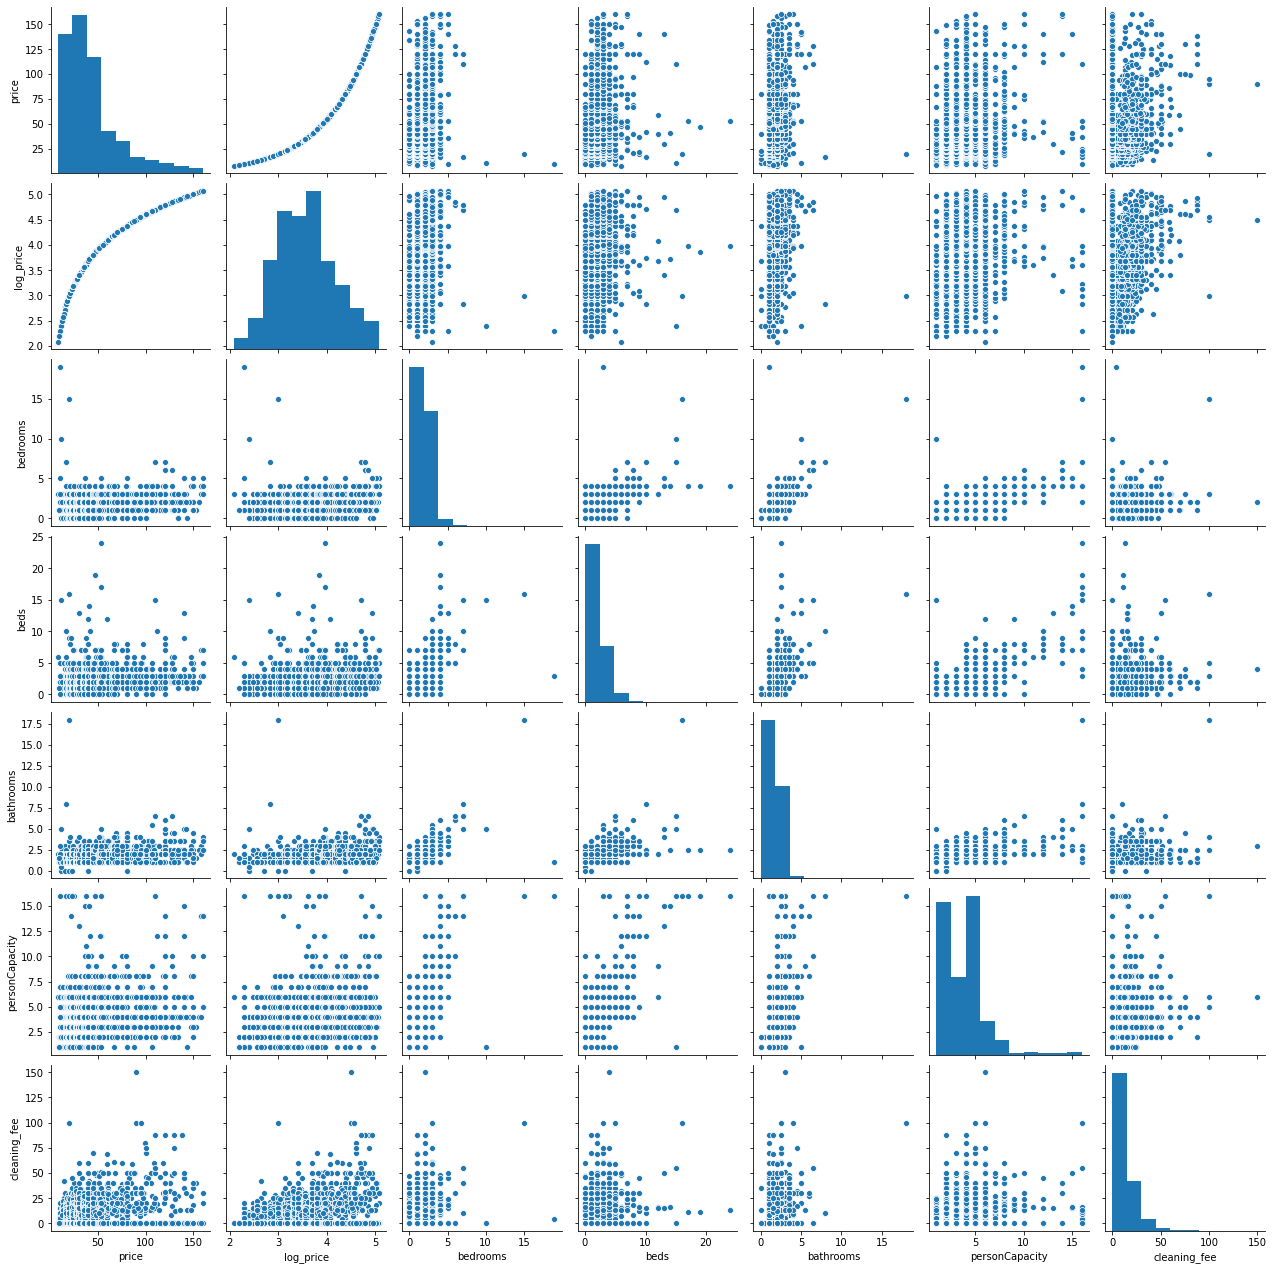

In [12]:
# Pairplot with unchanged feaures.
pair_plot_features = ['price', 'log_price', 'bedrooms', 'beds', 'bathrooms', 'personCapacity', 'cleaning_fee']
sns.pairplot(rooms[pair_plot_features]);

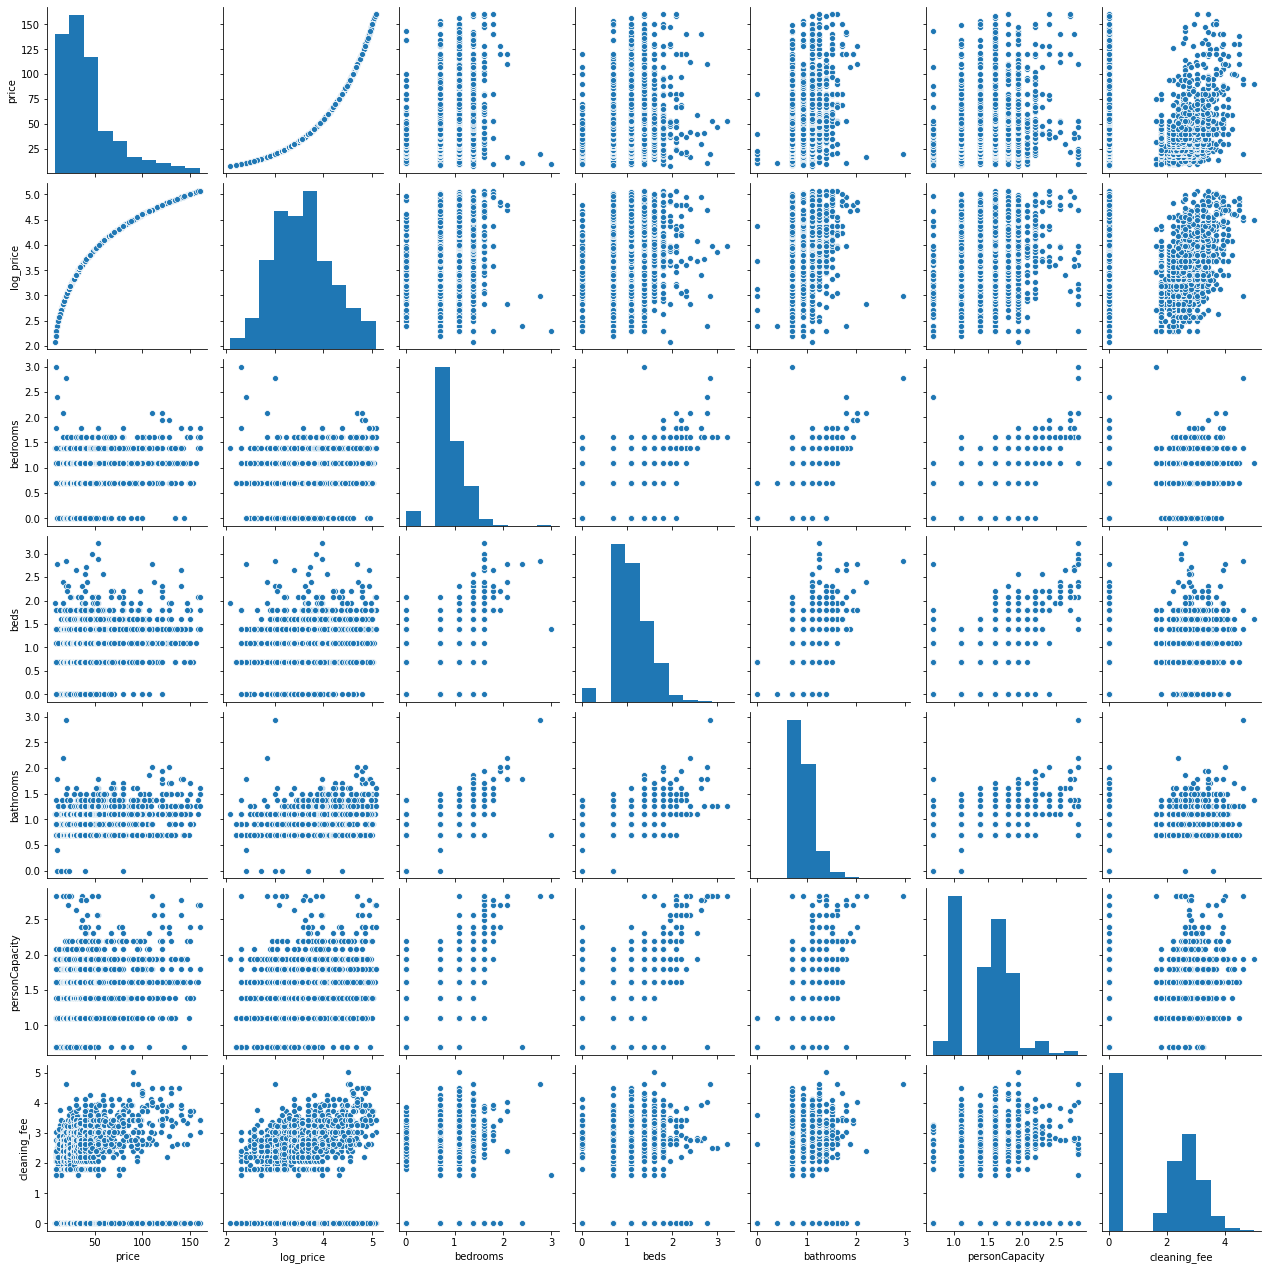

In [13]:
# Pairplot with logs of ['bedrooms', 'beds', 'bathrooms', 'personCapacity', 'cleaning_fee']
sns.pairplot(log_rooms[pair_plot_features]);

In [14]:
# Create DataFrames for train_test_split.
# One unchanged from original data as a control.
# One with the log of the selected features.
logs = ['bedrooms', 'beds', 'bathrooms', 'personCapacity']
X_r = rooms.drop(['price', 'log_price', 'lat', 'lng'], axis=1)
y_r = rooms['price']
X_l = rooms.drop(['price', 'log_price', 'lat', 'lng'], axis=1)
for item in logs:
    X_l[item] = np.log1p(X_l[item])
y_l = rooms['price']

______
**Xr_ prefix is for room data unchanged prior to the split.**  
**Xl_ prefix is for room data that has had np.log applied to some of the fields.**  

In [15]:
# Train test splits
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_r, y_r, test_size=0.2, random_state=SEED, stratify=np.floor(np.log2(y_r)))
Xl_train, Xl_test, yl_train, yl_test = train_test_split(X_l, y_l, test_size=0.2, random_state=SEED, stratify=np.floor(np.log2(y_l)))

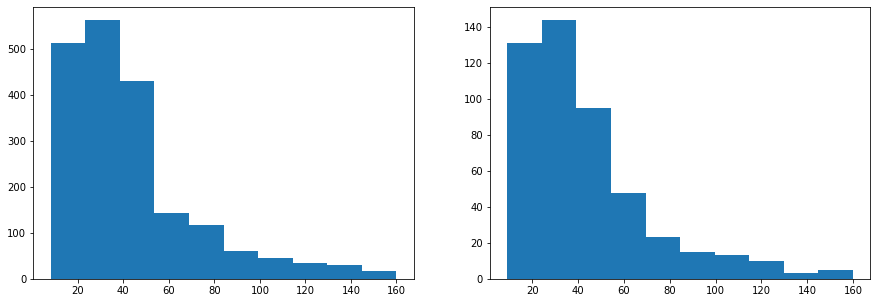

In [16]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(yr_train);
plt.subplot(1, 2, 2)
plt.hist(yr_test);

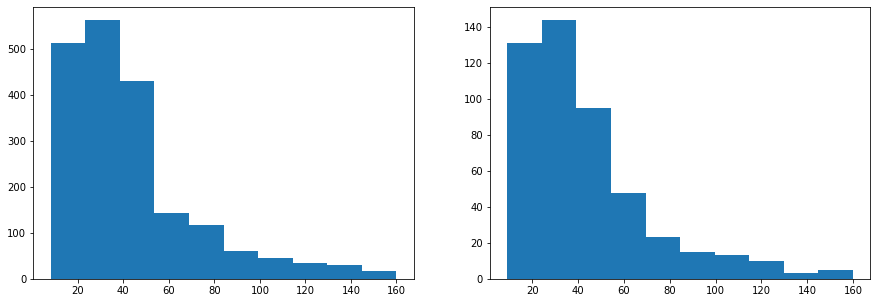

In [17]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(yl_train);
plt.subplot(1, 2, 2)
plt.hist(yl_test);

In [18]:
# Baseline regression to see p-Values
Xr_train_with_constant = sm.add_constant(Xr_train)
model = sm.OLS(yr_train, Xr_train_with_constant)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.192
Method:                 Least Squares   F-statistic:                     58.71
Date:                Sun, 09 Aug 2020   Prob (F-statistic):           5.45e-86
Time:                        16:15:37   Log-Likelihood:                -9085.9
No. Observations:                1948   AIC:                         1.819e+04
Df Residuals:                    1939   BIC:                         1.824e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -23.6095     13.483     -1.751      0.080     -50.053       2.834
cleaning_fee       0.3068      0.049      6.308      0.000       0.211       0.402
bedrooms          -1.2304      0.906     -1.359      0.174      -3.006       0.545
beds              -0.2541      0.597     -0.426      0.671      -1.425       0.917
bathrooms         11.0731      1.023     10.820      0.000       9.066      13.080
personCapacity     1.9881      0.504      3.944      0.000       0.999       2.977
reviewsCount      -0.0676      0.021     -3.247      0.001      -0.108      -0.027
isSuperhost       -3.0419      1.463     -2.079      0.038      -5.911      -0.173
avgRating          9.1652      2.876      3.187      0.001       3.524      14.806
==============================================================================
Omnibus:                      519.903   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3747.830
Skew:                           1.058   Prob(JB):                         0.00
Kurtosis:                       9.457   Cond. No.                         803.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
# Baseline regression to see p-Values
Xl_train_with_constant = sm.add_constant(Xl_train)
model = sm.OLS(yr_train, Xl_train_with_constant)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     74.91
Date:                Sun, 09 Aug 2020   Prob (F-statistic):          8.19e-108
Time:                        16:15:37   Log-Likelihood:                -9034.8
No. Observations:                1948   AIC:                         1.809e+04
Df Residuals:                    1939   BIC:                         1.814e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -42.2828     13.245     -3.192      0.001     -68.259     -16.307
cleaning_fee       0.2854      0.047      6.054      0.000       0.193       0.378
bedrooms          -1.0561      2.460     -0.429      0.668      -5.881       3.769
beds               1.3754      1.987      0.692      0.489      -2.522       5.272
bathrooms         42.8364      3.071     13.947      0.000      36.813      48.860
personCapacity     4.9266      2.425      2.032      0.042       0.171       9.682
reviewsCount      -0.0618      0.020     -3.044      0.002      -0.102      -0.022
isSuperhost       -2.7632      1.427     -1.937      0.053      -5.562       0.035
avgRating          7.9607      2.804      2.839      0.005       2.461      13.460
==============================================================================
Omnibus:                      529.746   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1544.040
Skew:                           1.391   Prob(JB):                         0.00
Kurtosis:                       6.359   Cond. No.                         808.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

______  
**It is interesting that neither bedrooms or beds seems to be particularly important to the model. Values that don't seem to correlate well such as reviewsCount, and avgRating are important.**

In [20]:
# Fit a LinearRegression with StandardScaler
pipe = make_pipeline(StandardScaler(), LinearRegression())
pipe.fit(Xr_train, np.log(yr_train))
yr_pred = pipe.predict(Xr_train)
r2_score(yr_pred, np.log(yr_train))

-3.0898844926477356

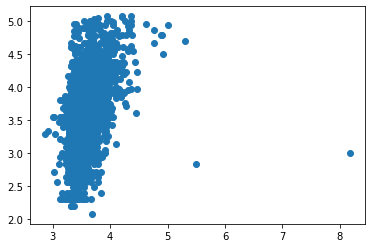

In [21]:
plt.scatter(yr_pred, np.log(yr_train));

In [22]:
# Fit a LinearRegression with StandardScaler
pipe = make_pipeline(StandardScaler(), LinearRegression())
pipe.fit(Xl_train, np.log(yl_train))
yl_pred = pipe.predict(Xl_train)
r2_score(yl_pred, np.log(yl_train))

-1.9763489853867044

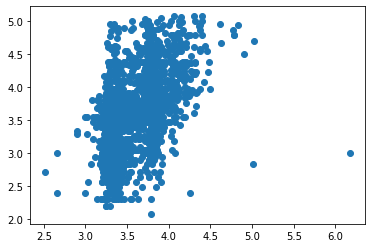

In [23]:
plt.scatter(yl_pred, np.log(yl_train));

In [24]:
Xr_train2 = Xr_train.drop(['reviewsCount', 'isSuperhost', 'avgRating'], axis=1)
pipe = make_pipeline(StandardScaler(), LinearRegression())
pipe.fit(Xr_train2, np.log(yr_train))
yr_pred = pipe.predict(Xr_train2)
r2_score(yr_pred, np.log(yr_train))

-3.3590138577152784

In [25]:
# Cross val score of scales but unchained input features.
pipe = make_pipeline(StandardScaler(), LinearRegression())
cross_val_score(pipe, Xr_train, yr_train)

array([-0.00984529,  0.21566887,  0.18714097,  0.24205832,  0.2200492 ])

In [26]:
# Cross val score with the log of input features i.e. ['bedrooms', 'beds', 'bathrooms', 'personCapacity']
pipe = make_pipeline(StandardScaler(), LinearRegression())
cross_val_score(pipe, Xl_train, yl_train)

array([0.17102273, 0.20894376, 0.2189986 , 0.27699315, 0.23763436])

______
**Logs of the input features ['bedrooms', 'beds', 'bathrooms', 'personCapacity'] appears to yield better results in general.**